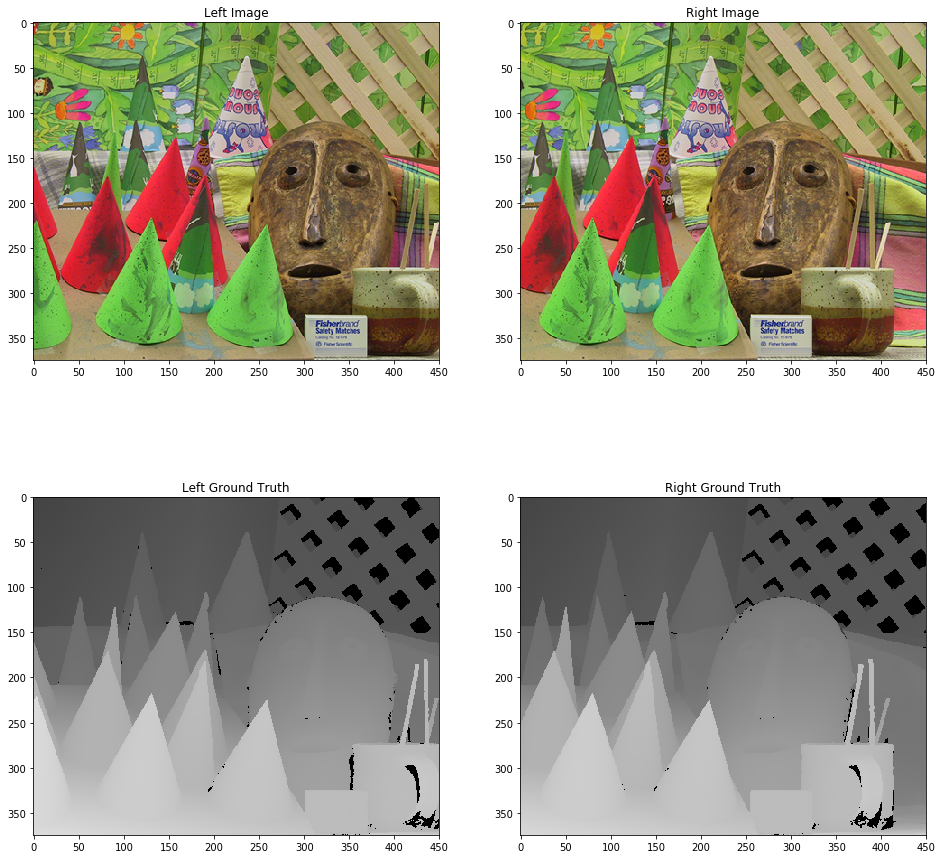

In [30]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.html.widgets import *
import sys

left_img_name = "cones-im2.png"
right_img_name = "cones-im6.png"

left_ground_truth_name = "cones-disp2.png"
right_ground_truth_name = "cones-disp6.png"

left_img = cv.imread(left_img_name)
right_img = cv.imread(right_img_name)

left_ground_truth = cv.imread(left_ground_truth_name)
right_ground_truth = cv.imread(right_ground_truth_name)

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1, title='Left Image')
plt.imshow(cv.cvtColor(left_img, cv.COLOR_BGR2RGB))
plt.subplot(2, 2, 2, title='Right Image')
plt.imshow(cv.cvtColor(right_img, cv.COLOR_BGR2RGB))

plt.subplot(2, 2, 3, title='Left Ground Truth')
plt.imshow(left_ground_truth)
plt.subplot(2, 2, 4, title='Right Ground Truth')
plt.imshow(right_ground_truth)

plt.show()

# Convert to Grayscale
left_img_gray = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
right_img_gray = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

In [3]:
def stereoBM_ssd(im_l, im_r, b_size, disparityRange):
    """ Find disparity image using Sum of Squared Differences. """
    
    print('Starting Block Matching SSD')
    
    m, n = im_r.shape

    # Array to hold depth planes
    dmaps = np.zeros((m, n))
    
    # Block matching with nested for-loops
    for r in range(m):
        minr = max(0, r-b_size)
        maxr = min(m-1, r+b_size)
        for c in range(n):
            minc = max(0, c-b_size)
            maxc = min(n-1, c+b_size)
            
            # Calculate Disparity Range
            mind = disparityRange[0]
            maxd = min(disparityRange[1], n-maxc)
            
            # Construct template from the right image
            template = im_r[minr:maxr, minc:maxc]

            # Search template in the left image - Calculate SSD
            numBlocks = maxd - mind
            scores = cv.matchTemplate(im_l[minr:maxr, minc+mind:minc+maxd], template, method=cv.TM_SQDIFF_NORMED)
            
            # Find the index of the best matched region
            # It is the disparity
            matched_idx = np.argmin(scores)
            dmaps[r, c] = matched_idx + mind
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
        
    return dmaps

def stereoBM_ncc(im_l, im_r, b_size, disparityRange):
    """ Find disparity image using Normalised Cross Correlation. """
    
    print('Starting Block Matching NCC')
    
    m, n = im_r.shape

    # Array to hold depth planes
    dmaps = np.zeros((m, n))
    
    # Block matching with nested for-loops
    for r in range(m):
        minr = max(0, r-b_size)
        maxr = min(m-1, r+b_size)
        for c in range(n):
            minc = max(0, c-b_size)
            maxc = min(n-1, c+b_size)
            
            # Calculate Disparity Range
            mind = disparityRange[0]
            maxd = min(disparityRange[1], n-maxc)
            
            # Construct template from the right image
            template = im_r[minr:maxr, minc:maxc]

            # Search template in the left image - Calculate NCC
            numBlocks = maxd - mind
            scores = cv.matchTemplate(im_l[minr:maxr, minc+mind:minc+maxd], template, method=cv.TM_CCORR_NORMED)
                
            # Find the index of the best matched region
            # It is the disparity
            matched_idx = np.argmax(scores)
            dmaps[r, c] = matched_idx + mind
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
        
    return dmaps

def createMask(dmap, fRange):
    
    x, y = fRange
    
    if x >= 255:
        print('X value must be less than 255, It should be at most the maximum value in the Disparity Range.')
        return
    
    temp = np.copy(dmap)
    temp[(temp < x) | (temp > y)] = 255
    temp[(temp >= x) & (temp <= y)] = 0
    
    return temp

In [4]:
dmap_6_ssd = stereoBM_ssd(left_img_gray, right_img_gray, 4, [0, 64])

Starting Block Matching SSD


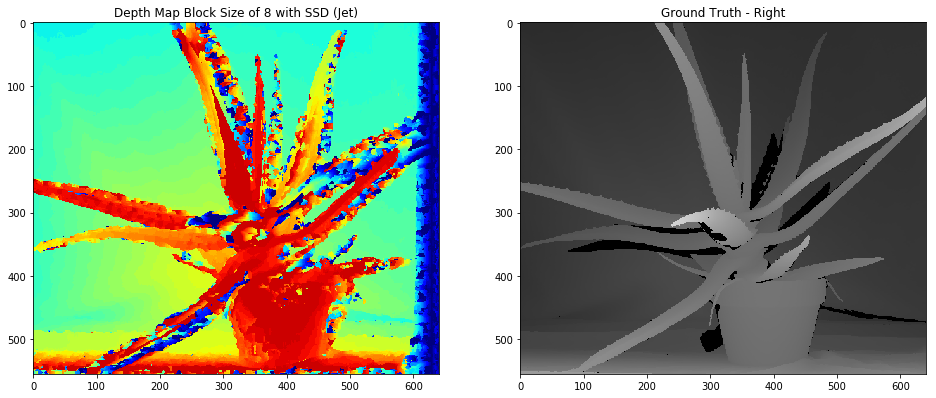

In [22]:
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1, title='Depth Map Block Size of 8 with SSD (Jet)')
plt.imshow(dmap_6_ssd, cmap='jet')
plt.subplot(1, 2, 2, title='Ground Truth - Right')
plt.imshow(right_ground_truth)
plt.show()

In [21]:
def masking(x, y):
    dmap_6_ssd_mask = createMask(dmap_6_ssd, (x, y))
    
    smooth_img = np.copy(right_img)
    temp = smooth_img[dmap_6_ssd_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_6_ssd_mask == 0] = temp
    
    plt.figure(figsize = (16, 16))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_6_ssd_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
interact(masking, x=(0, 64, 1), y=(0, 64, 1))

interactive(children=(IntSlider(value=32, description='x', max=64), IntSlider(value=32, description='y', max=6…

<function __main__.masking(x, y)>

In [31]:
dmap_6_ncc = stereoBM_ncc(left_img_gray, right_img_gray, 4, [0, 64])

Starting Block Matching NCC


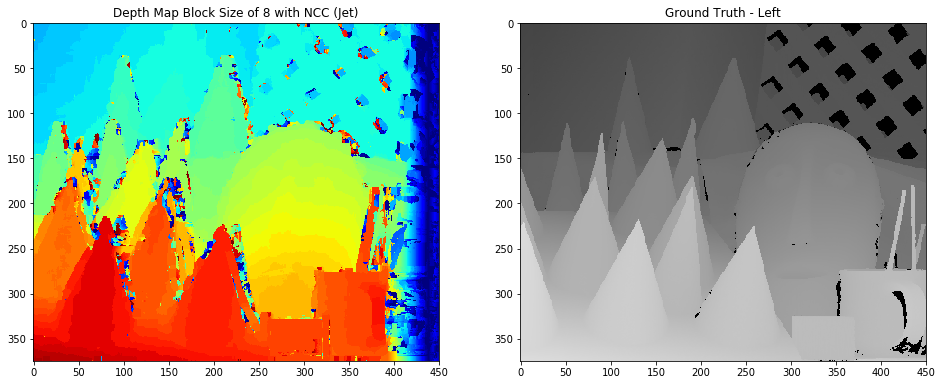

In [32]:
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1, title='Depth Map Block Size of 8 with NCC (Jet)')
plt.imshow(dmap_6_ncc, cmap='jet')
plt.subplot(1, 2, 2, title='Ground Truth - Left')
plt.imshow(left_ground_truth)
plt.show()

In [33]:
def masking(x, y):
    dmap_6_ncc_mask = createMask(dmap_6_ncc, (x, y))
    
    smooth_img = np.copy(right_img)
    temp = smooth_img[dmap_6_ncc_mask == 0]
    smooth_img = cv.GaussianBlur(smooth_img, (7, 7), 3)
    smooth_img[dmap_6_ncc_mask == 0] = temp
    
    plt.figure(figsize = (16, 16))
    plt.subplot(1, 2, 1, title='Mask')
    plt.imshow(dmap_6_ncc_mask, cmap='gray')
    plt.subplot(1, 2, 2, title='Blurred Image')
    plt.imshow(smooth_img)
    plt.show()
    
interact(masking, x=(0, 64, 1), y=(0, 64, 1))

interactive(children=(IntSlider(value=32, description='x', max=64), IntSlider(value=32, description='y', max=6…

<function __main__.masking(x, y)>

In [14]:
def stereoDP(im_l, im_r, b_size, disparityRange):
    """ Find disparity image using Normalised Cross Correlation. """
    
    print('Starting Block Matching NCC')
    
    m, n = im_r.shape
    
    dsi = np.ones((n, 2*disparityRange[1])) * 1e3
    
    # Build Disparity Space Image
    for r in range(m):
        minr = max(0, r-b_size)
        maxr = min(m-1, r+b_size)
        for c in range(n):
            minc = max(0, c-b_size)
            maxc = min(n-1, c+b_size)
            
            # Calculate Disparity Range
            mind = disparityRange[0]
            maxd = min(disparityRange[1], n-maxc)
            
            # Set window in the Right Image
            right = im_r[minr:maxr, minc:maxc]
            
            for d in range(mind, maxd):
                left = im_l[minr:maxr, minc+d:maxc+d]
                dsi[c, d+disparityRange[1]] = np.sum(cv.matchTemplate(left, right, method=cv.TM_CCORR_NORMED))
        
        sys.stdout.write('Row %d/%d \r' % (r+1, m))
        sys.stdout.flush()
    
    plt.imshow(dsi)
    
    return dsi

Starting Block Matching NCC


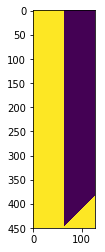

In [15]:
test = stereoDP(left_img_gray, right_img_gray, 4, [0, 64])